# Load Data

## Dog Images

In [93]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
dog_files, dog_targets = load_dataset('dogImages/train')


## Faces

In [94]:
# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))

## Preview data

In [95]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline 
def plot_image(image_file):
    img = cv2.imread(image_file)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

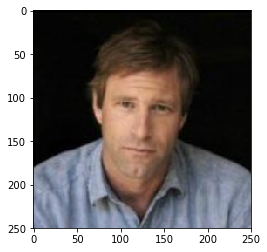

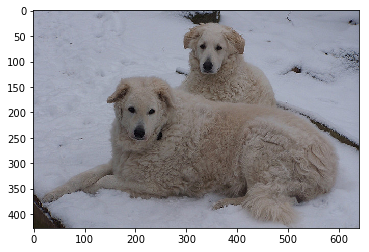

In [96]:
plot_image(human_files[0])
plot_image(dog_files[0])

## Merge Datasets

In [97]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_3dtensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    return x

def paths_to_3dtensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [98]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# keep 100 items per category for testing
face_detection_files = dog_files[0:1000]
face_detection_test_files = dog_files[-100:]
face_detection_targets = np.zeros(len(face_detection_files))
face_detection_test_targets = np.zeros(len(face_detection_test_files))

# Add face items
human_train_files = human_files[0:1000]
human_test_files = human_files[-100:]
face_detection_files = np.vstack([face_detection_files[:, None], human_train_files[:, None]])
face_detection_targets = np.vstack([face_detection_targets[:, None], np.ones(len(human_train_files))[:, None]]) 

face_detection_test_files = np.vstack([face_detection_test_files[:, None], human_test_files[:, None]])
face_detection_test_targets = np.vstack([face_detection_test_targets[:, None], np.ones(len(human_test_files))[:, None]]) 

# Load Images
face_detection_train = [path_to_tensor(img_path[0]) for img_path in face_detection_files]
face_detection_test = [path_to_tensor(img_path[0]) for img_path in face_detection_test_files]

In [99]:
import keras
from numpy  import array
from keras.utils import np_utils
train_x = array(face_detection_train)
train_y = array(face_detection_targets)

test_x = array(face_detection_test)
test_y = array(face_detection_test_targets)

# one-hot encode the labels
num_classes = len(np.unique(train_y))
train_y = keras.utils.to_categorical(train_y, num_classes)
test_y = keras.utils.to_categorical(test_y, num_classes)

train_x.shape

(2000, 64, 64, 3)

### Rescale pixel values to 0-1

In [100]:
train_x = train_x.astype('float32')/255
test_x = test_x.astype('float32')/255



# Define a CNN

In [101]:
from keras.models import Sequential
from keras.layers import Flatten, Conv2D, MaxPooling2D, Dense, Dropout,GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 16, 16, 32)        0         
__________

In [102]:
from keras import optimizers
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [103]:
from keras.callbacks import ModelCheckpoint, EarlyStopping   

# train the model
checkpointer = ModelCheckpoint(filepath='face_recognition2.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
hist = model.fit(train_x, train_y, batch_size=128, epochs=1,
          validation_split=0.1, callbacks=[checkpointer, early_stopping], 
          verbose=1, shuffle=True)

Train on 1800 samples, validate on 200 samples
Epoch 1/1
1800/1800 [==============================] - 28s - loss: 8.5391 - acc: 0.4367 - val_loss: 1.2100e-07 - val_acc: 1.0000


In [83]:
# load the weights that yielded the best validation accuracy
model.load_weights('face_recognition.weights.best.hdf5')

In [84]:
score = model.evaluate(test_x, test_y, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.985


In [85]:
def face_detector(img_path):
    features = path_to_tensor(img_path)
    features = features.astype('float32')/255
    y_hat = model.predict(np.array([features]))
    return y_hat[0][0] < 0.5

In [88]:
import random
random.shuffle(human_files)
random.shuffle(dog_files)

face_detector(human_files[0])

True

In [89]:
face_detector(dog_files[0])

False

Human Detected: 100.0%


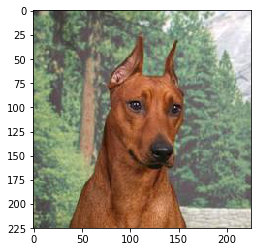

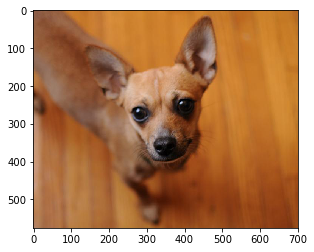

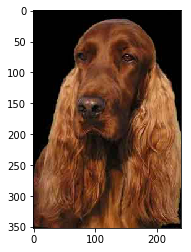

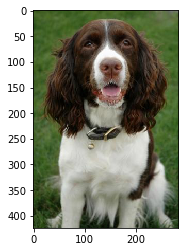

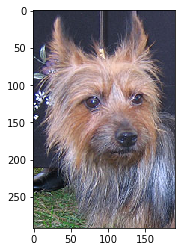

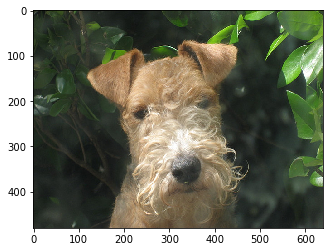

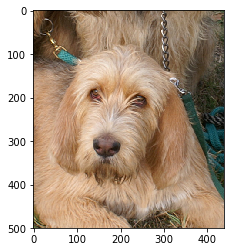

Human Detected in Dogs: 1.4000000000000001%


In [92]:
human_files_short = human_files[:500]
dog_files_short = dog_files[:500]

human_detected = 0
for human_file in human_files_short:
    if face_detector(human_file):
        human_detected += 1
    else:
        plot_image(human_file)
print("Human Detected: " + str(human_detected/len(human_files_short)*100) + "%")

dogs_detected = 0
for dog_file in dog_files_short:
    if face_detector(dog_file):
        dogs_detected += 1
        plot_image(dog_file)
print("Human Detected in Dogs: " + str(dogs_detected/len(dog_files_short)*100) + "%")

In [44]:
x[0:-2]

array([1, 2, 3, 4, 5, 6, 7])